<a href="https://colab.research.google.com/github/iurykischka/Proc.-de-sinais/blob/master/Trabalho_Processamento_de_Sinais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt, IPython.display as ipd
from scipy.io import wavfile
from scipy import signal
import requests

# Som do beat
response = requests.get('https://github.com/iurykischka/Proc.-de-sinais/blob/master/untitled.wav?raw=true')
open("untitled.wav", "wb").write(response.content)
fs, beat = wavfile.read('untitled.wav')
beat = beat[:,0] # sinal do beat

tempo = np.arange(len(beat))/fs # variável TEMPO (em segundos)


<ipython-input-86-38a4e59222d4>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, beat = wavfile.read('untitled.wav')


In [ ]:
ipd.Audio(beat, rate=fs, normalize=True)

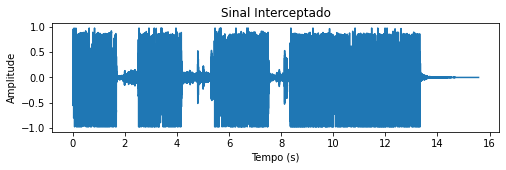

In [ ]:
T = 1/fs #período
N=len(beat) #comprimento do sinal

t1 = np.arange(0, N*T, T) #vetor de tempo (segundos)
plt.figure(figsize=(8,2)) #figura para plotagem
plt.plot(t1, beat) #plotagem no domínio do tempo
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal Interceptado");

In [ ]:
import numpy as np, matplotlib.pyplot as plt, scipy as sp
from scipy import signal

def serieFourier(x, t, Hz=False, dB=False, deg=False, Nfft=None):
    N = len(x)
    T = np.mean(t[1:]-t[:-1])
        
    if Nfft==None: Nfft=N
        
    Xk = sp.fft.fft(x, Nfft) 
    Xk = Xk/min(N,Nfft) 
    Xk = Xk[:Nfft//2] 
    Xk[1:] = 2*Xk[1:] 
    Xk_mag  = np.abs(Xk)
    if dB: Xk_mag = 20*np.log10(Xk_mag)
    Xk_pha = np.angle(Xk, deg=deg)

    # Calculo das frequencias
    f0 = 2*np.pi/(Nfft*T) # rad/s
    freqs = np.arange(0.,(Nfft//2)*f0, f0)
    freqs = freqs[0:Nfft//2]
    if Hz: freqs /= 2*np.pi
    
    return Xk_mag,Xk_pha,freqs

#Calcular a FFt
def plotFFT(x, t, Hz=True, db=False):
    Xk_mag,Xk_pha,freqs = serieFourier(x, t, Hz=Hz, dB=db, deg=True, Nfft=None)
    if db:
        plt.semilogx(freqs,Xk_mag)
    else:
        plt.plot(freqs,Xk_mag)
        
    if Hz:
        plt.xlabel("Frequencia(Hz)")
    else:
        plt.xlabel("Frequencia(rad/Amostra)")
    
    plt.ylabel("Módulo")
    plt.grid(which="both")
    
    return

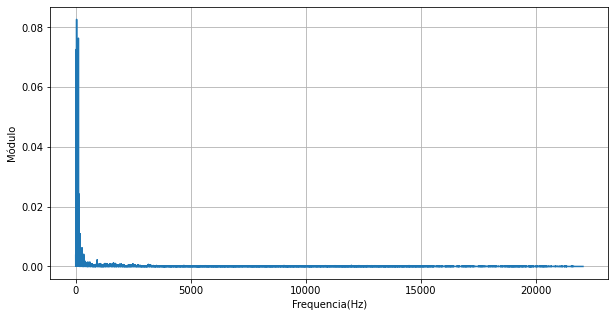

In [ ]:
plt.figure(figsize=(10,5))
plotFFT(beat, t1)

Ordem dos filtros: 1


/usr/local/lib/python3.8/dist-packages/scipy/signal/filter_design.py:689: UserWarning: The group delay is singular at frequencies [0.000], setting to 0
  warnings.warn(


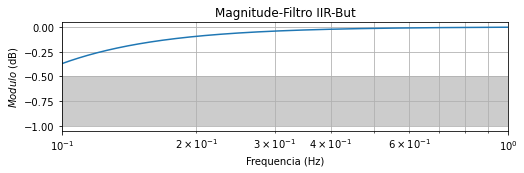

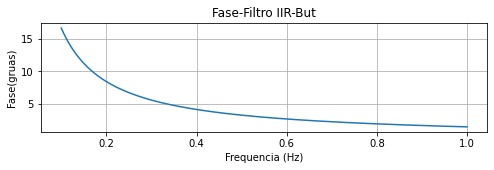

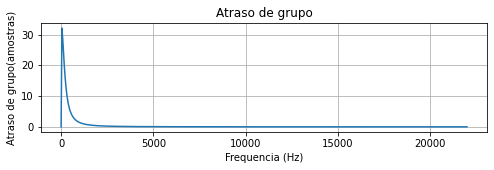

In [ ]:
Ap = 0.5 ### Muda valor
Ar = 1 ### Muda valor
Gp = -Ap
Gr = -Ar
dp = 1 - 10**(Gp/20)
dr = 10**(Gr/20)
delta = min(dp,dr) #Pegar menor ripple ( olhar valor de dp e dr para saber)
delta_db = 20*np.log10(delta)

#frequencia de corte em hz
fp = 600
fr = 200
ftr= (fr-fp)
ftr_norm = ftr/(fs/2)
fc = np.mean((fp,fr))

#frequencia de corte em rad/s
ws = 2*np.pi*fs
wp = 2*np.pi*fp
wr = 2*np.pi*fr

# PROJETO DO FILTRO DISCRETO IIR

#Ordem do filtro
N2, wn2 = signal.buttord(wp=fp, ws=fr, gpass=Ap, gstop=Ar, analog=False, fs=fs) #Butterworth
print("Ordem dos filtros:", N2)

#Projeto do filtro
z2, p2, k2 = signal.butter(N=N2, Wn=wn2, btype="highpass", analog=False, output="zpk", fs=fs) #Butterworth
sysIIR = signal.dlti(z2, p2, k2)

#Diagrama de Bode
w = np.logspace(-1, 0, 4000)
w2, mag_2, ph_2 = signal.dbode(sysIIR, w)

#Rad/amostra para Hz
w2= w/(2*np.pi)*fs

# Gráfico (módulo)
plt.figure(figsize = (8,2))
plt.title("Magnitude-Filtro IIR-But")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("$ Modulo $ (dB)")
plt.semilogx(w, mag_2);
plt.fill([min(w), fp,  fp,  min(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda passagem
plt.fill([max(w), fr,  fr,  max(w)], [-Ar, -Ar, -Ap, -Ap], '0.8', lw=0) # banda rejeição
plt.xlim(0.1, 1)
plt.grid(which="both")

# Gráfico (fase)
plt.figure(figsize = (8,2))
plt.plot(w, np.unwrap(ph_2)) 
plt.title("Fase-Filtro IIR-But")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Fase(gruas)")
plt.grid(which="both")

(n, d) = signal.zpk2tf(sysIIR.zeros, sysIIR.poles, sysIIR.gain)

#Atrado de grupo
f_iir, grd_iir = signal.group_delay((n,d), fs=fs)
plt.figure(figsize=(8,2))
plt.plot(f_iir, grd_iir)
plt.title("Atraso de grupo")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Atraso de grupo(amostras)")
plt.grid(which="both")

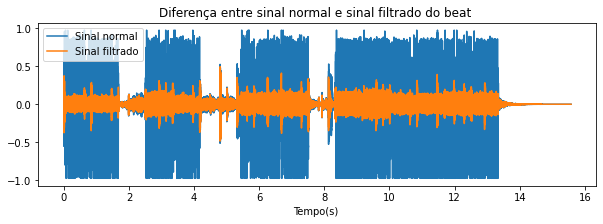

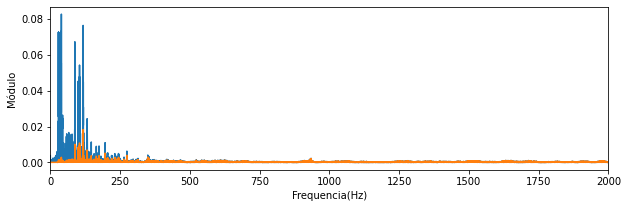

In [ ]:
atraso = np.mean(grd_iir)/fs
tempo_atraso = tempo-atraso

a, b = signal.zpk2tf(sysIIR.zeros, sysIIR.poles, sysIIR.gain)
beat_y2 = signal.filtfilt(a, b, beat) 

plt.figure(figsize=(10,3))
plt.plot(tempo, beat,label = "Sinal normal")
plt.plot(tempo, beat_y2,label = "Sinal filtrado" )
plt.title("Diferença entre sinal normal e sinal filtrado do beat ")
plt.xlabel("Tempo(s) ")
legend = plt.legend(loc='upper left')

#Pós filtro
plt.figure(figsize=(10,3))
plotFFT(beat, tempo, Hz=True, db=False)
plotFFT(beat_y2, tempo_atraso, Hz=True, db=False)
plt.xlim((0,2000));

ipd.Audio(beat_y2, rate=fs, normalize=True)